#Colab 搭配 OpenVINO Pretrained Model 影像語義分割範例

使用OpenVINO加上Public預訓練模型deeplabv3來進行影像語義分割，可適用於VOC Dataset 21分類（含背景類）之影像分割。    

歐尼克斯實境互動工作室 OmniXRI Jack, 2022.05.03 整理製作

# 1. 安裝Intel OpenVINO工具包
以apt方式安裝OpenVINO，安裝版本為 2021.4.572  
預設安裝路徑為/opt/intel/OpenVINO_2021.4.572，系統會自建出/opt/intel/  OpenVINO_2021捷徑名稱，後續可使用這個較短捷徑名稱。  
若想安裝其它版本，可透過下列指令進行查詢。  
!apt-cache search intel-openvino

In [1]:
# 顯示目前工作目錄
!pwd
# 取得OpenVINO 2021公開金錀
!wget https://apt.repos.intel.com/openvino/2021/GPG-PUB-KEY-INTEL-OPENVINO-2021 
# 加入OpenVINO公開金錀到系統金錀群中
!apt-key add GPG-PUB-KEY-INTEL-OPENVINO-2021 
# 建立更新安裝清單檔案
!touch /etc/apt/sources.list.d/intel-openvino-2021.list
# 將下載指令加入安裝清單中
!echo "deb https://apt.repos.intel.com/openvino/2021 all main" >> /etc/apt/sources.list.d/intel-openvino-2021.list
# 更新系統
!apt update
# 安裝OpenVINO到虛擬機系統中
!apt install intel-openvino-dev-ubuntu18-2021.4.752
# 列出安裝路徑下內容進行確認
!ls /opt/intel

/content
--2022-05-03 08:22:30--  https://apt.repos.intel.com/openvino/2021/GPG-PUB-KEY-INTEL-OPENVINO-2021
Resolving apt.repos.intel.com (apt.repos.intel.com)... 23.218.183.111, 2600:1402:3800:2ab::4b23, 2600:1402:3800:2aa::4b23
Connecting to apt.repos.intel.com (apt.repos.intel.com)|23.218.183.111|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 939 [binary/octet-stream]
Saving to: ‘GPG-PUB-KEY-INTEL-OPENVINO-2021’

GPG-PUB-KEY-INTEL-O 100%[===================>]     939  --.-KB/s    in 0s      

2022-05-03 08:22:30 (129 MB/s) - ‘GPG-PUB-KEY-INTEL-OPENVINO-2021’ saved [939/939]

OK
Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 https://apt.repos.intel.com/openvino/2021 all InRelease [5,659 B]
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:5 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:6

# 2. 下載影像分割模型
可選用下列Public預訓練模型，更多可選用模型可參考
https://docs.openvino.ai/latest/omz_models_group_public.html#semantic-segmentation-models    

*   deeplabv3
*   drn-d-38
*   hrnet-v2-c1-segmentation
*   fastseg-large
*   fastseg-small
*   pspnet-pytorch
*   ocrnet-hrnet-w48-paddle

這裡選用 **--name deeplabv3** （可自行變更所需模型名稱）  
注意！執行OpenVINO功能前記得設定環境變數（setupvars.sh），否則會得到錯誤訊息。  


In [2]:
# 執行環境設定批次檔並以模型下載器取得模型
!source /opt/intel/openvino_2021/bin/setupvars.sh && \
python /opt/intel/openvino_2021/deployment_tools/tools/model_downloader/downloader.py \
--name deeplabv3

[setupvars.sh] OpenVINO environment initialized
################|| Downloading deeplabv3 ||################

========== Downloading /content/public/deeplabv3/deeplabv3.tar.gz
... 100%, 23323 KB, 44661 KB/s, 0 seconds passed

========== Unpacking /content/public/deeplabv3/deeplabv3.tar.gz



# 3. 模型優化
如果下載的是Intel's Pretrained Model則不需轉換就自帶IR檔(xml,bin)  
若是Public Pretrained Model則須進行轉換成IR檔，系統會自動判別。  
--name 參數為待轉換模型名稱  

In [3]:
# 下載及安裝test-generator 方便檢查程式運行錯誤
!pip install test-generator==0.1.1

# 執行環境設定批次檔並將下載到的模型檔進行優化轉換產生IR(xml & bin)檔
!source /opt/intel/openvino_2021/bin/setupvars.sh && \
python /opt/intel/openvino_2021/deployment_tools/tools/model_downloader/converter.py \
--name deeplabv3

[setupvars.sh] OpenVINO environment initialized
========== Converting deeplabv3 to IR (FP16)
Conversion command: /usr/bin/python3 -m mo --framework=tf --data_type=FP16 --output_dir=/content/public/deeplabv3/FP16 --model_name=deeplabv3 --reverse_input_channels '--input_shape=[1,513,513,3]' --input=1:mul_1 --output=ArgMax --input_model=/content/public/deeplabv3/deeplabv3_mnv2_pascal_train_aug/frozen_inference_graph.pb

Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	/content/public/deeplabv3/deeplabv3_mnv2_pascal_train_aug/frozen_inference_graph.pb
	- Path for generated IR: 	/content/public/deeplabv3/FP16
	- IR output name: 	deeplabv3
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	1:mul_1
	- Output layers: 	ArgMax
	- Input shapes: 	[1,513,513,3]
	- Mean values: 	Not specified
	- Scale values: 	Not specified
	- Scale factor: 	Not specified
	- Precision of IR: 	FP16
	- Enable fusing: 	True
	- Enable grouped convolutions 

檢查模型轉檔後會產生/FP16, FP16-INT8, FP32不同精度的IR檔(xml, bin)

In [4]:
!ls /content/public/deeplabv3
!ls /content/public/deeplabv3/FP32

deeplabv3_mnv2_pascal_train_aug  FP16  FP32
deeplabv3.bin  deeplabv3.mapping  deeplabv3.xml


# 4. 準備測試用影像

## 4.1 下載測試影像

從網路獲取任意一張測試影像並另存成input.jpg並顯示。  
若要從Github中取得影像時，需將原檔案路徑修改為原始檔型式。  
首先在Github原始影像上以滑鼠右鍵點擊，選擇「複製圖片鏈結」取得影像原始網址，例：  
https://github.com/OmniXRI/NTUST_EdgeAI_2022/blob/main/Ch7_Implementations/Dataset/image_segmentation_01.jpg  
接著修改後檔名：主要是將github.com變成raw.githubusercontent.com，把/blob/main改成master路徑名稱，其它子路徑保留  
https://raw.githubusercontent.com/OmniXRI/NTUST_EdgeAI_2022/master/Ch7_Implementations/Dataset/image_segmentation_01.jpg


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  del sys.path[0]


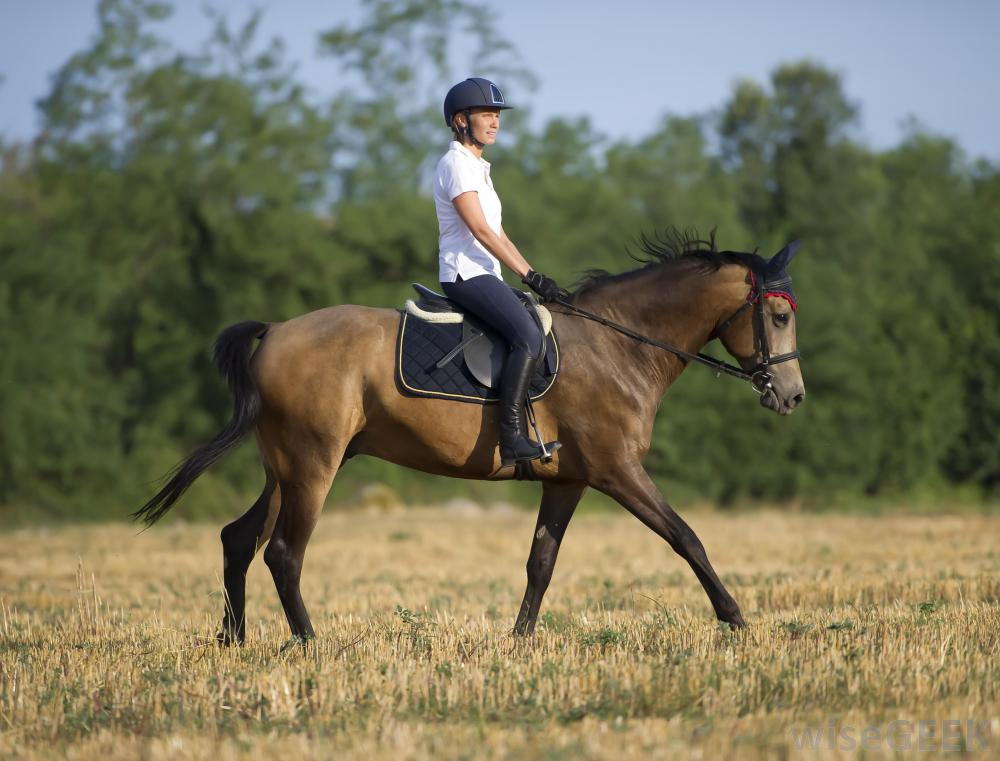

In [5]:
# 以OpenCV檢視輸入影像
import cv2 # 導入OpenCV套件包
from google.colab.patches import cv2_imshow # 導入顯示OpenCV格式影像套件包
import numpy as np # 導入numpy套件包
import requests # 導入requests套件包

# Github獲取一張影像
file = requests.get("https://raw.githubusercontent.com/OmniXRI/NTUST_EdgeAI_2022/master/Ch7_Implementations/Dataset/image_segmentation_01.jpg")
# 從網路獲取一張影像
#file = requests.get("http://i1.kknews.cc/lYJLb30M_z3aDTTYleALzOnQD3sjzbL_3MVdLEw/0.jpg")

# 將影像轉成OpenCV格式存檔並顯示
img = cv2.imdecode(np.fromstring(file.content, np.uint8), 1)
cv2.imwrite('input.jpg',img)
cv2_imshow(img) # 顯示輸入影像

為更清楚了解物件偵測範例程式可支援的模型，可將models.lst及使用方式列出來確認。（此步驟可忽略）

In [6]:
!ls /opt/intel/openvino_2021/deployment_tools/inference_engine/demos/segmentation_demo/python/
# 列出可支援的模型名稱及對應的結構類型(architecture_type)
!cat /opt/intel/openvino_2021/deployment_tools/inference_engine/demos/segmentation_demo/python/models.lst
# 列出物件偵測程式的參數說明文件
!cat /opt/intel/openvino_2021/deployment_tools/inference_engine/demos/segmentation_demo/python/README.md

models.lst  README.md  segmentation_demo.py
# This file can be used with the --list option of the model downloader.
# For --architecture_type=segmentation
deeplabv3
fastseg-large
fastseg-small
hrnet-v2-c1-segmentation
icnet-camvid-ava-????
icnet-camvid-ava-sparse-??-????
pspnet-pytorch
road-segmentation-adas-????
semantic-segmentation-adas-????
unet-camvid-onnx-????
# For --architecture_type=salient_object_detection
f3net
# Image Segmentation Python\* Demo

![example](../segmentation.gif)

This topic demonstrates how to run the Image Segmentation demo application, which does inference using semantic segmentation networks.

> **NOTE:** This topic describes usage of Python\* implementation of the Image Segmentation Demo. For the C++ implementation, refer to [Image Segmentation C++ Demo](../cpp/README.md).

## How It Works

On startup the demo application reads command line parameters and loads a network. The demo runs inference and shows results for each image captured from an input. Dem

#5. 進行推論
執行環境設定批次檔並執行推論  

輸入參數：  
-d 執行裝置，預設為CPU (Colab提供的Intel Xeon CPU),Colab不支援Intel的GPU,MYRIAD(VPU),FPGA   
-at 結構樣式  
-i 輸入影像名稱 (\*.png, \*.jpg ...)  
-m 模型名稱 (\*.xml)  
-o 輸出結果名稱 (\*.png, \*.jpg ...)  

最後顯示推論結果

VOC Dataset 21 分類（含背景）依序為：  
*   background
*   person
*   bird
*   cat
*   cow
*   dog
*   horse
*   sheep
*   aeroplane
*   bicycle
*   boat
*   bus
*   car
*   motorbike
*   train
*   bottle
*   chair
*   dining table
*   potted plant
*   sofa
*   tv/monitor

[setupvars.sh] OpenVINO environment initialized
/usr/local/lib/python3.7/dist-packages/scipy/fft/__init__.py:97: DeprecationWarning: The module numpy.dual is deprecated.  Instead of using dual, use the functions directly from numpy or scipy.
  from numpy.dual import register_func
/usr/local/lib/python3.7/dist-packages/scipy/sparse/sputils.py:17: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  supported_dtypes = [np.typeDict[x] for x in supported_dtypes]
/usr/local/lib/python3.7/dist-packages/scipy/special/orthogonal.py:81: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy

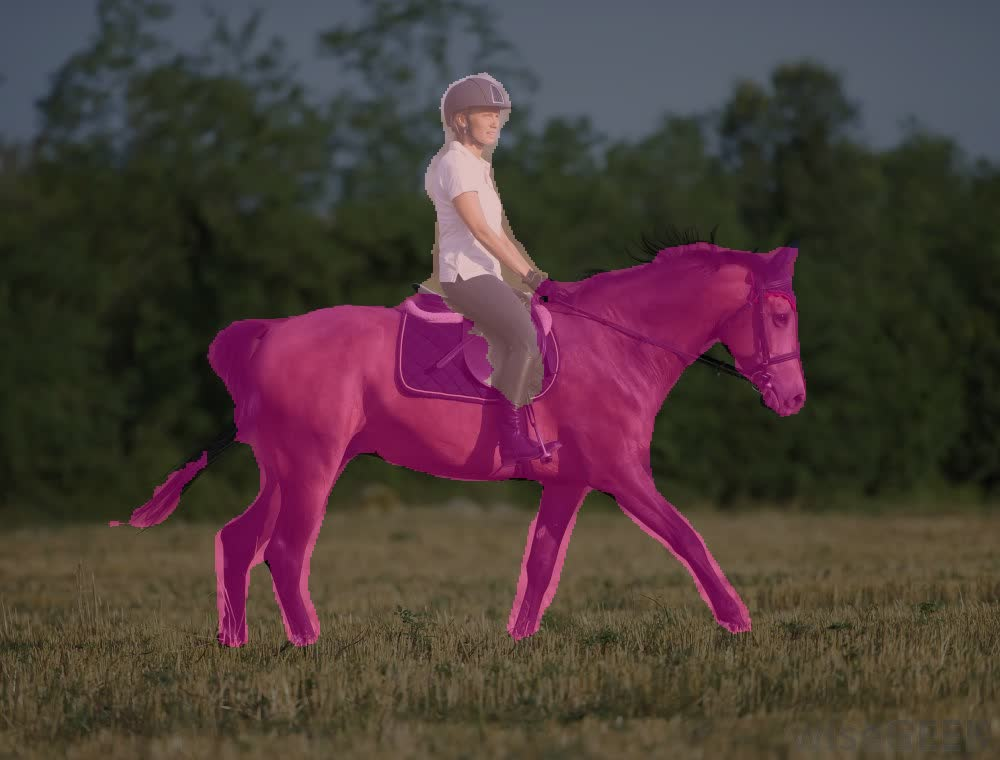

In [7]:
!source /opt/intel/openvino_2021/bin/setupvars.sh && \
python \
/opt/intel/openvino_2021/deployment_tools/inference_engine/demos/segmentation_demo/python/segmentation_demo.py \
-at segmentation \
-i 'input.jpg' \
-m /content/public/deeplabv3/FP32/deeplabv3.xml \
-o 'output.jpg'

out_img = cv2.imread("output.jpg") # 讀入結果影像
cv2_imshow(out_img) # 顯示結果影像 